In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torchmetrics

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
import cv2
from PIL import Image
from os import path
from pathlib import Path
import os
import glob

In [2]:
TRAIN_DIR = 'CCPD2019-dl1/train/'
TEST_DIR = 'CCPD2019-dl1/test/'
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 80
BATCH_SIZE = 15
NUM_WORKERS = 10

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, src, targets, resize, filters=True):
        self.img_list = src
        self.targets = targets
        self.resize = resize
        self.filters = filters
        # Normilize img
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        
        self.to_tensor = transforms.Compose([transforms.ToTensor()])


        self.normalize = transforms.Compose(
        [
            transforms.Normalize(mean, std),
        
        ])
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, indx):
        img = Image.open(f'{self.img_list[indx]}').convert('RGB')
        img = img.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
        target = self.targets[indx]
        target = torch.tensor(target, dtype=torch.long)
        
        img = self.to_tensor(img)
        
        # Добавляем фильтров - повышаем яркость у темных изображений и увеличиваем резкость с подавлением шумов
        if self.filters:
            img = img.permute((1, 2, 0)).numpy()*255
            mean_bright = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).mean() 
            if mean_bright < 80 :
                brightness_increase = 127 - mean_bright
                brightened_image = np.clip(img + brightness_increase, 0, 255)
                
            elif mean_bright > 250 :
                brightened_image = np.clip(img - 30, 0, 255)
            img = cv2.convertScaleAbs(img, beta=20)
            img = cv2.detailEnhance(img, sigma_s=10, sigma_r=0.1)
            img = cv2.bilateralFilter(img, 3, 75, 175)
#             img = cv2.bilateralFilter(img, 2, 75, 75)
            img = torch.Tensor(img).permute((2,0,1))
        
        return (self.normalize(img), target)

In [4]:
# Получим таргеты 
train_imgs = os.listdir(TRAIN_DIR)
test_imgs = os.listdir(TEST_DIR)
train_imgs_path = [TRAIN_DIR + path for path in train_imgs]
test_imgs_path = [TEST_DIR + path for path in test_imgs]

train_targets_original = [label.split(sep='-')[1].split('.')[0] for label in train_imgs]
test_targets_original = [label.split(sep='-')[1].split('.')[0] for label in test_imgs]

# все таргеты
all_targets = train_targets_original + test_targets_original

In [5]:
# найдем уникальные таргеты
targets = [[token for token in one_target] for one_target in all_targets]
unique_tokens = {token for target in targets for token in target}

# напишем кодировщик
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(list(unique_tokens))
len(label_encoder.classes_)

66

In [6]:
#кодируем трейн
train_targets = [[token for token in one_target] for one_target in train_targets_original]
train_targets_encoded = [label_encoder.transform(one_target) for one_target in train_targets]
train_targets_encoded = np.array(train_targets_encoded)
train_targets_encoded = train_targets_encoded + 1

#кодируем тест
test_targets = [[token for token in one_target] for one_target in test_targets_original]
test_targets_encoded = [label_encoder.transform(one_target) for one_target in test_targets]
test_targets_encoded = np.array(test_targets_encoded)
test_targets_encoded = test_targets_encoded + 1

In [7]:
train_imgs, valid_imgs, train_targets, valid_targets, _, valid_targets_orig = train_test_split(
        train_imgs_path, train_targets_encoded, train_targets_original, test_size=0.08, random_state=42
    )

### Сформируем датасеты

In [8]:
train_dataset = Dataset(train_imgs, train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH), filters=False)

valid_dataset = Dataset(valid_imgs, valid_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH), filters=False)

test_dataset = Dataset(test_imgs_path, test_targets_encoded, resize=(IMAGE_HEIGHT, IMAGE_WIDTH), filters=False)

### Сформируем Dataloaders

In [9]:
train_datalader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

### Смотрим вывод даталоадера

In [10]:
# tmp = (next(iter(train_datalader)))
# print(tmp[0][1])
# plt.imshow(tmp[0][0].permute(1, 2, 0)*255)

### Модель

In [11]:
class Ocr(nn.Module):
    def __init__(self, num_chars):
        super().__init__()

        #будем идти прямоугольным ядром тк картина прямоугольная 
        self.sec0 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=(3, 6), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        self.sec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3, 6), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        self.linear = nn.Sequential(
            nn.Linear(64*20, 64),
            nn.Dropout(0.2),
            nn.LSTM(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        )
        
        self.out = nn.Linear(64, num_chars + 1)

    def forward(self, x, targets=None):
        batch_size, _, _, _ = x.size()

        x = self.sec0(x)

        x = self.sec1(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(batch_size, x.size(1), -1) 

        x, _ = self.linear(x)
        x = self.out(x) 

        # меняем размерность под CTCLoss
        x = x.permute(1, 0, 2) 

        if targets is not None:
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(
                size=(batch_size,), fill_value=log_probs.size(0), dtype=torch.int32
            )
            target_lengths = torch.full(
                size=(batch_size,), fill_value=targets.size(1), dtype=torch.int32
            )
            loss = nn.CTCLoss(blank=0)(
                log_probs, targets, input_lengths, target_lengths
            )
            return x, loss

        return x, None

In [12]:
# model = OCR(len(label_encoder.classes_))
# img = torch.rand((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH))
# model(img)[0].size()

In [12]:
# Инициализируем модель
model = Ocr(len(label_encoder.classes_))
device = 'cuda'
model = model.to(device)

In [13]:
# оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=7, verbose=True)

In [14]:
model = torch.load('model_ocr.pth')

### Train, Evaluate functions

In [15]:
def train(model, dataloader, optimizer, device='cuda'):
    model.train()
    model = model.to(device)
    train_range = tqdm(dataloader)
    epoch_loss = 0
    for data in train_range:
        optimizer.zero_grad()
        
        img, target = data
        img, target = img.to(device), target.to(device)
        
        _, loss = model(img, target)
        
        train_range.set_postfix_str(str(float(loss.item())))
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss/len(dataloader)


def evaluate(model, dataloader, device='cuda'):
    model = model.to(device)
    loss_score = 0
    preds_arr = []
    model.eval()
    with torch.no_grad():
        data_range = tqdm(dataloader)
        for data in data_range:
            img, target = data
            img, target = img.to(device), target.to(device)
            
            preds, loss = model(img, target)
            
            preds_arr.append(preds.detach().cpu())
            loss_score += loss.item()
            
    return preds_arr, loss_score/len(dataloader)

    

In [16]:
def remove_duplicates(x):
    if len(x) < 2:
        return x
    fin = ""
    for j in x:
        if fin == "":
            fin = j
        else:
            if j == fin[-1]:
                continue
            else:
                fin = fin + j
    return fin


def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    #выбираем наиболее вероятных символ по предсказаниям
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()

    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            k -= 1
            if k == -1:
                temp.append("+") #символ который не встречается
            else:
                p = encoder.inverse_transform([k])[0] #декодиркем
                temp.append(p)
        
        temp = "".join(temp)
        temp = remove_duplicates(temp) #выполняем задачу декодера 1)
        tp = "".join(temp).replace("+", "") #выполняем задачу декодера 2)
        cap_preds.append(tp) 
    return cap_preds


## Обучение

In [17]:
max_acc = 0
for epoch in range(1):

    train_loss = train(model, train_datalader, optimizer)
    torch.save(model, 'model.pth')
    valid_preds, test_loss = evaluate(model, valid_dataloader)
    
    valid_number_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, label_encoder)
        valid_number_preds.extend(current_preds)

    combined = list(zip(valid_targets_orig, valid_number_preds))
    print(combined[:10])

    valid_dup_rem = [remove_duplicates(c) for c in valid_targets_orig]
    accuracy = metrics.accuracy_score(valid_dup_rem, valid_number_preds)
    if accuracy > max_acc:
        torch.save(model, 'model_ocr.pth')
        max_acc = accuracy
    print(
        f"Epoch={epoch}, Train Loss={train_loss}, Evaluation={test_loss} Accuracy={accuracy}"
    )

    scheduler.step(test_loss)

100%|██████████| 1067/1067 [00:17<00:00, 60.07it/s]


[('皖A92C20', '皖A92C20'), ('皖A34S67', '皖A34S67'), ('皖ARR620', '皖ARR620'), ('皖A229K2', '皖A229K2'), ('皖AJL366', '皖AJL366'), ('皖AJB921', '皖AJB921'), ('皖ALY464', '皖ALY464'), ('皖HXT993', '皖HXT993'), ('皖A90B09', '皖A90B09'), ('皖ACC998', '皖AUC998')]
Epoch=0, Train Loss=0.0073948369444187595, Evaluation=0.005940840266600876 Accuracy=0.6874179636227264


In [15]:
model = torch.load('model_ocr.pth')

In [18]:
test_preds, test_loss = evaluate(model, test_dataloader)

100%|██████████| 667/667 [00:11<00:00, 58.73it/s]


In [19]:
number_preds = []

for vp in test_preds:
        current_preds = decode_predictions(vp, label_encoder)
        number_preds.extend(current_preds)

combined = list(zip(test_targets_original, number_preds))
print(combined[:10])

[('皖KHW812', '皖AKHW812'), ('皖A2T138', '皖A2T138'), ('皖HZW010', '皖HZW010'), ('皖AKY728', '皖AKY728'), ('皖ABX176', '皖ABX176'), ('皖AW8P09', '皖AW8P09'), ('皖QG8788', '皖QG8788'), ('皖A800T1', '皖A800T1'), ('皖AT696L', '皖AT696L'), ('皖A89R59', '皖A89R59')]


## Посмотрим на метрики

In [20]:
# accuracy
metrics.accuracy_score(test_targets_original, number_preds)

0.9588958895889589

In [21]:
# char_error_rate
torchmetrics.functional.char_error_rate(number_preds, test_targets_original)

tensor(0.0078)

## Анализ ошибок модели

In [26]:
img_name, ocr_output = zip(*combined)

In [33]:
error_fn = torchmetrics.functional.char_error_rate
errors = [error_fn(real, pred).item() for real, pred in zip(img_name, ocr_output)]

In [35]:
# находим самые проблемные картинки
bigest_error = np.argsort(np.array(errors))[-50:][::-1].tolist()


[2981,
 9146,
 8571,
 4865,
 1489,
 4741,
 8280,
 3035,
 2006,
 9761,
 3329,
 1765,
 7098,
 6534,
 6901,
 7777,
 5940,
 158,
 4789,
 4580,
 1162,
 8530,
 7712,
 2446,
 9119,
 3959,
 8295,
 2336,
 8021,
 2078,
 9481,
 1504,
 4638,
 1163,
 6848,
 6427,
 2060,
 8849,
 3535,
 4816,
 4396,
 9605,
 9788,
 6834,
 6235,
 9408,
 8283,
 7137,
 5374,
 3136]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


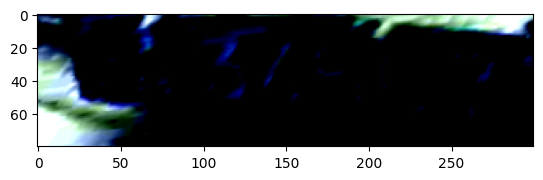

In [51]:
plt.imshow(test_dataset[7777][0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


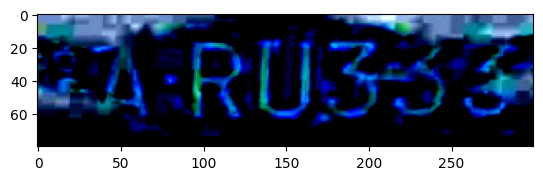

In [45]:
plt.imshow(test_dataset[9408][0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


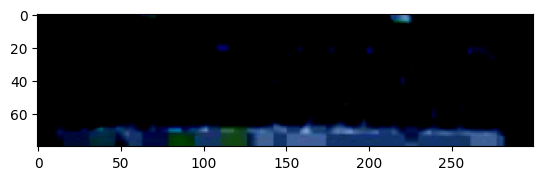

In [48]:
plt.imshow(test_dataset[4741][0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


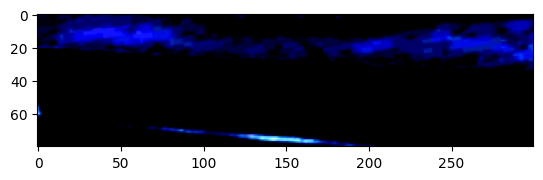

In [40]:
plt.imshow(test_dataset[2981][0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


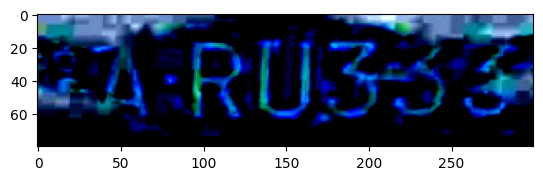

In [52]:
plt.imshow(test_dataset[9408][0].permute(1, 2, 0))

In [58]:
tmp, _ = model(test_dataset[9408][0].unsqueeze(0).cuda())
decode_predictions(tmp, label_encoder)

['ZRU333']

## Модель ошибается на картинках, где крайне плохо видно символы или они вообще замылены.

### Добавление каких-то фильтров (пробовал сделать картинку ярче, повысить контрастность, выделить детали и сгладить шумы) сильно не улучшило скор

### Из идей для доработки:
1) Еще больше потратить времени и найти подходящие фильтры для улучшения фото
2) Добавить затемняющих или замыливающих аугментаций при обучении
3) Использовать какие-то предобученные сети для восстановления изображений

## Final score:

### accuracy = 0.95,  Char Error Rate = 0.0078